# 0. Preliminaries

In [1]:
import json
import random
import os
from PIL import Image
from itertools import product
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from collections import Counter

from domain import SYM2PROG, Program, NULL_VALUE
import sys

In [2]:
symbol_images_dir = 'symbol_images/'
splits = ['train', 'val', 'test']

min_num = 0
max_num = 10
num_list = list(map(str, range(min_num, max_num)))
nonzero_num_list = [x for x in num_list if x != '0']
op_list = ['+', '-', '*', '/']
lps = '('
rps = ')'

print(num_list)
print(op_list, lps, rps)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['+', '-', '*', '/'] ( )


In [3]:
def render_img(img_paths):
    images = [Image.open(symbol_images_dir + x) for x in img_paths]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    return new_im

# 1. Split handwritten symbols

In [4]:
# split train and test set of math symbols
random.seed(777)
terminals = ['+', '-', 'times', 'div', '(', ')', '!'] + list(map(str, list(range(10)))) + ['alpha', 'beta', 'gamma', 'theta', 'phi'] + list('abcdexyz')
sym_train_set = {}
sym_val_set = {}
sym_test_set = {}
for tok in terminals:
    imgs = os.listdir(symbol_images_dir + tok)
    random.shuffle(imgs)
    n_train = int(len(imgs) * 0.75)
    n_val = int(len(imgs) * 0.05)
    sym_train_set[tok] = sorted(imgs[:n_train])
    sym_val_set[tok] = sorted(imgs[n_train:n_train+n_val])
    sym_test_set[tok] = sorted(imgs[n_train+n_val:])
    print(tok, len(imgs))
json.dump(sym_train_set, open('sym_train.json', 'w'))
json.dump(sym_val_set, open('sym_val.json', 'w'))
json.dump(sym_test_set, open('sym_test.json', 'w'))

+ 5443
- 6022
times 600
div 157
( 3986
) 3978
! 224
0 1810
1 6327
2 6210
3 2469
4 1641
5 1008
6 812
7 753
8 731
9 742
alpha 383
beta 295
gamma 90
theta 543
phi 83
a 2724
b 1830
c 1194
d 1062
e 616
x 5333
y 1895
z 1075


# 2. Generate expressions

In [5]:
random.seed(777)
class Iterator:
    def __init__(self, l, shuffle=True):
        if shuffle: 
            random.shuffle(l)
        self.list = l
        self.current = -1
        self.shuffle = shuffle
    
    def next(self):
        self.current += 1
        if self.current == len(self.list):
            self.current = 0
            if self.shuffle:
                random.shuffle(self.list)
        return self.list[self.current]

tok_convert = {'*': 'times', '/': 'div', 'a': 'alpha', 'b': 'beta', 'c': 'gamma', 'd': 'phi', 'e': 'theta'}
def generate_img_paths(tokens, sym_set):
    img_paths = []
    for tok in tokens:
        if tok in tok_convert:
            tok = tok_convert[tok]
        
        img_name = sym_set[tok].next()
        img_paths.append(os.path.join(tok, img_name))   
        
    return img_paths

split2sym = {}
for split in splits:
    sym_set = {k:Iterator(v) for k,v in json.load(open('sym_%s.json'%split)).items()}
    split2sym[split] = sym_set

In [6]:
class Node:
    def __init__(self, index, symbol, smt, prob=0.):
        self.index = index
        self.symbol = symbol
        self.smt = smt
        self.children = []
        self.sym_prob = prob
        self._res = None
        self._res_computed = False

    def res(self):
        if self._res_computed:
            return self._res

        self._res = self.smt(*self.inputs())
        if isinstance(self._res, int) and self._res > sys.maxsize:
            self._res = None
        self.prob = self.sym_prob + np.log(self.smt.likelihood) + sum([x.prob for x in self.children])
        self._res_computed = True
        return self._res

    def inputs(self):
        return [x.res() for x in self.children if x.res() is not NULL_VALUE]

class AST: # Abstract Syntax Tree
    def __init__(self, pt, semantics):
        self.pt = pt
        self.semantics = semantics

        nodes = [Node(i, s, semantics[s]) for i, s in enumerate(pt.sentence)]

        for node, h in zip(nodes, pt.head):
            if h == -1:
                self.root_node = node
                continue
            nodes[h].children.append(node)
        self.nodes = nodes

        self.root_node.res()
    
    def res(self): return self.root_node.res()
    
    def res_all(self): return [nd._res for nd in self.nodes]

In [7]:
op2precedence = {'+': 1, '-': 1, '*': 2, '/': 2, '!': 3}
op2arity = {'+': 2, '-': 2, '*': 2, '/': 2, '!': 1}

def parse_infix(expr):
    values = []
    operators = []
    
    head = [-1] * len(expr)
    for (i,sym) in enumerate(expr):
        if sym.isdigit():
            values.append(i)
        elif sym == lps:
            operators.append(i)
        elif sym == rps:
            while expr[operators[-1]] != lps:
                op = operators.pop()
                for _ in range(op2arity[expr[op]]):
                    head[values.pop()] = op
                values.append(op)
            i_lps = operators[-1]
            i_rps = i
            head[i_lps] = op
            head[i_rps] = op
            operators.pop()
        else:
            while len(operators) > 0 and expr[operators[-1]] != lps and \
                op2precedence[expr[operators[-1]]] >= op2precedence[sym]:
                op = operators.pop()
                for _ in range(op2arity[expr[op]]):
                    head[values.pop()] = op
                values.append(op)
            operators.append(i)

    while len(operators) > 0:
        op = operators.pop()
        for _ in range(op2arity[expr[op]]):
            head[values.pop()] = op
        values.append(op)

    root_op = values.pop()
    head[root_op] = -1
    assert len(values) == 0

    return head

def parse_prefix(expr):
    head = [-1] * len(expr)
    arity = [op2arity.get(x, 0) for x in expr]
    for i in range(len(expr)):
        if i == 0: 
            head[i] = -1
            continue
        for j in range(i-1, -1, -1):
            if arity[j] > 0:
                break
        head[i] = j
        arity[j] -= 1
        #print(i, head, arity)

    return head

def flatten(expr):
    if len(expr) == 1:
        return expr
    return [y for x in expr for y in flatten(x)]

def prefix2infix(prefix):
    prefix = list(prefix)
    values = []
    while len(prefix) > 0:
        sym = prefix.pop()
        if sym.isdigit():
            values.append([sym])
        else:
            arity = op2arity[sym]
            precedence = op2precedence[sym]
            
            left = values.pop()
            right = values.pop() if arity == 2 else []
            """
            add parenthesis when:
            (1) left is a compound expression and its operator's precedence < the current operator
            (2) right is a compound expression and its operator's precedence <= the current operator
            here we assume that the operator is left-associative.
            """
            if len(left) > 1 and op2precedence[left[1]] < precedence:
                left = [lps] + left + [rps]
            if len(right) > 1 and op2precedence[right[1]] <= precedence:
                right = [lps] + right + [rps]
                
            new_value = [left, sym, right]
            values.append(new_value)
    
    infix = ''.join(flatten(values.pop()))
    assert len(values) == 0
    return infix

from collections import namedtuple
Parse = namedtuple('Parse', 'sentence head')
def eval_expr(expr, head):
    ast = AST(Parse(expr, head), SYM2PROG)
    return ast.res(), ast.res_all()
    
def eval_expr_by_eval(expr):
    expr_for_eval = []
    for symbol in expr:
        if symbol == '!':
            expr_for_eval[-1] = 'math.factorial(' + expr_for_eval[-1] + ')'
        elif symbol == '/':
            expr_for_eval.append('//')
        else:
            expr_for_eval.append(symbol)
#     try:
#         res = eval("".join(expr_for_eval))
#     except OverflowError:
#         res = None
    res = eval("".join(expr_for_eval))
    return res



expr = '6*(5-2)'
head = parse_infix(expr)
res = eval_expr(expr, head)
print(expr, res, head)

expr = '/+64-31'
head = parse_prefix(expr)
res = eval_expr(expr, head)
print(expr, res, head)

expr = prefix2infix(expr)
head = parse_infix(expr)
res = eval_expr(expr, head)
print(expr, res, head)

6*(5-2) (18, [6, 18, -1, 5, 3, 2, -1]) [1, -1, 4, 4, 1, 4, 4]
/+64-31 (5, [5, 10, 6, 4, 2, 3, 1]) [-1, 0, 1, 1, 0, 4, 4]
(6+4)/(3-1) (5, [-1, 6, 10, 4, -1, 5, -1, 3, 2, 1, -1]) [2, 2, 5, 2, 2, -1, 8, 8, 5, 8, 8]


In [8]:
def enumerate_expression(n_op):
    if n_op == 0:
        return [[x] for x in num_list]
    
    expressions = []
    
    arity = 1
    ops = [op for op in op_list if op2arity[op] == arity]
    inputs = enumerate_expression(n_op-1)
    expressions.extend(product(ops, inputs))
    
    arity = 2
    ops = [op for op in op_list if op2arity[op] == arity]
    inputs = []
    for i in range(n_op):
        input_1 = enumerate_expression(i)
        input_2 = enumerate_expression(n_op - 1 - i)
        inputs.extend(product(input_1, input_2))
    expressions.extend(product(ops, inputs))
    
    expressions = [flatten(x) for x in expressions]
    return expressions

def sample_expression(n_op, n_instances, min_value=0, max_value=float('inf'), non_zero_res=False):
    def sample(n_op):
        if n_op == 0:
            return [random.choice(num_list)]
        op = random.choice(op_list)
        if op2arity[op] == 1:
            return [op] + sample(n_op-1)
        else:
            i = random.randint(0, n_op-1)
            j = n_op - 1 - i
            return [op] + sample(i) + sample(j)
    
    expressions = []
    with tqdm(total=n_instances) as pbar:
        while len(expressions) < n_instances:
            expr = sample(n_op)
            if expr in expressions:
                continue
            head = parse_prefix(expr)
            res, res_all = eval_expr(expr, head)
            if res is not None:
                if non_zero_res and res == 0:
                    continue
                max_res = max([x for x in res_all if x is not None])
                if max_res >= min_value and max_res <= max_value:
                    expressions.append(expr)
                    pbar.update(1)
    return expressions

def generate_expression(n_op, n_instances, min_value=0, max_value=float('inf'), non_zero_res=False):
    if n_op <= 2:
        expressions = []
        for expr in enumerate_expression(n_op):
            head = parse_prefix(expr)
            res, res_all = eval_expr(expr, head)
            if res is not None:
                if non_zero_res and res == 0:
                    continue
                max_res = max([x for x in res_all if x is not None])
                if max_res >= min_value and max_res <= max_value:
                    expressions.append(expr)
    else:
        assert n_instances is not None
        expressions = sample_expression(n_op, n_instances, min_value, max_value, non_zero_res)
    random.shuffle(expressions)
    expressions = expressions[:n_instances]
    
    temp = []
    for expr in expressions:
        expr = prefix2infix(expr)
        head = parse_infix(expr)
        res, res_all = eval_expr(expr, head)
        if res is not None:
            temp.append((expr, head, res, res_all))
    
    return temp

In [10]:
random.seed(12306)
max_op = 20
max_op_train = 10
max_value_train = 100
max_value_test = 10000
n_train = 100000
n_test = 1000
n_val = 100

train_exprs = []
val_exprs = []
test_exprs = []

for n_op in range(max_op + 1):
    if n_op > max_op_train:
        n_train = 0
    expressions = generate_expression(n_op, n_train + n_val + n_test, max_value=max_value_train)
    
    if n_train > 0:
        train_exprs.append(expressions[:n_train])
    val_exprs.append(expressions[:min(n_val, n_train)] + expressions[n_train:n_train+n_val])
    test_exprs.append(expressions[:min(n_test, n_train)] + expressions[n_train+n_val:])
    
    expressions = generate_expression(n_op, n_val + n_test, 
                          min_value=max_value_train+1, max_value=max_value_test, non_zero_res=True)
    val_exprs[-1].extend(expressions[:n_val])
    test_exprs[-1].extend(expressions[n_val:n_val+n_test])

    print(n_op, len(train_exprs[-1]) if n_train > 0 else 0, len(val_exprs[-1]), len(test_exprs[-1]))

target_train = int(1e6)
n_train = target_train - sum([len(x) for x in train_exprs])
expressions = generate_expression(max_op_train, n_train, max_value=max_value_train)
train_exprs[-1].extend(expressions)

target_test = int(5e4)
target_val = int(0.1 * target_test)
n_test = target_test - sum([len(x) for x in test_exprs])
n_val = target_val - sum([len(x) for x in val_exprs])
expressions = generate_expression(n_op, n_val + n_test, 
                    min_value=max_value_train+1, max_value=max_value_test, non_zero_res=True)
val_exprs[-1].extend(expressions[:n_val])
test_exprs[-1].extend(expressions[n_val:n_val+n_test])

    
split2exprs = {'train': train_exprs, 'val': val_exprs, 'test': test_exprs}
print([(k, sum([len(x) for x in v])) for k, v in split2exprs.items()])

0 10 10 10
1 390 100 390


  1%|▍                         | 1493/101100 [00:00<00:06, 14923.50it/s]

2 29230 200 1640


  1%|▎                         | 1353/101100 [00:00<00:07, 13518.67it/s]

3 100000 300 3000


  1%|▎                         | 1041/101100 [00:00<00:09, 10402.20it/s]

4 100000 300 3000


  1%|▎                         | 1127/101100 [00:00<00:08, 11263.46it/s]

5 100000 300 3000


  2%|▍                          | 1558/101100 [00:00<00:12, 7804.99it/s]

6 100000 300 3000


  1%|▏                           | 837/101100 [00:00<00:11, 8368.37it/s]

7 100000 300 3000


  1%|▏                           | 670/101100 [00:00<00:14, 6697.93it/s]

8 100000 300 3000


  1%|▏                           | 608/101100 [00:00<00:16, 6066.61it/s]

9 100000 300 3000


 46%|█████████████▊                | 506/1100 [00:00<00:00, 5057.06it/s]

10 100000 300 3000


 45%|█████████████▎                | 490/1100 [00:00<00:00, 4896.36it/s]

11 0 200 2000


 36%|██████████▊                   | 395/1100 [00:00<00:00, 3949.24it/s]

12 0 200 2000


 31%|█████████▍                    | 345/1100 [00:00<00:00, 3449.66it/s]

13 0 200 2000


 29%|████████▊                     | 323/1100 [00:00<00:00, 3223.64it/s]

14 0 200 2000


 26%|███████▋                      | 281/1100 [00:00<00:00, 2786.87it/s]

15 0 200 2000


 23%|██████▉                       | 254/1100 [00:00<00:00, 2508.23it/s]

16 0 200 2000


 19%|█████▋                        | 210/1100 [00:00<00:00, 2092.20it/s]

17 0 200 2000


 18%|█████▎                        | 197/1100 [00:00<00:00, 1963.86it/s]

18 0 200 2000


 15%|████▍                         | 162/1100 [00:00<00:00, 1619.49it/s]

19 0 200 2000


  0%|                            | 607/170370 [00:00<00:28, 6062.42it/s]

20 0 200 2000


100%|██████████████████████████████| 4250/4250 [00:11<00:00, 355.53it/s]


[('train', 1000000), ('val', 5000), ('test', 50000)]


In [11]:
split2dataset = {}
for split in splits:
    sym_set = split2sym[split]
    exprs = split2exprs[split]
    dataset = []
    idx = 0
    for n_op, expr_list in enumerate(exprs):
        if n_op == 0:
            n_instance = 100
        elif n_op == 1:
            n_instance = 10
        else:
            n_instance = 1
        
        if split == 'val':
            n_instance *= 0.1
        n_instance = int(math.ceil(n_instance))
#         print(n_op, n_instance, len(expr_list) * n_instance)
        for e in expr_list:
            if split in ['val', 'test']:
                if e[0] in train_exprs:
                    evaluation = 'I'
                else:
                    max_value = max([x for x in e[3] if x is not None])
                    evaluation = 'S' if n_op <= max_op_train else 'L'
                    evaluation += 'S' if max_value <= max_value_train else 'L'
            
            for _ in range(n_instance):
                img_paths = generate_img_paths(e[0], sym_set)
                sample = {'id': '%s_%08d'%(split, idx), 'img_paths':img_paths, 
                      'expr': e[0], 'head': e[1], 'res': e[2], 'res_all': e[3]}
                if split in ['val', 'test']:
                    sample['eval'] = evaluation
                idx += 1
                dataset.append(sample)
    split2dataset[split] = dataset
    if split == 'train':
        train_exprs = {x['expr'] for x in dataset}
    print(split, len(dataset))
for split in splits:
    json.dump(split2dataset[split], open('expr_%s.json'%split, 'w'))

train 1004500
val 5090
test 54500


In [12]:
counts = sorted(Counter([x['eval'] for x in split2dataset['test']]).items())
total_count = sum([c for _, c in counts])
counts = [(k, v, round(v/total_count*100, 2)) for k, v in counts]
print(counts)

[('I', 13900, 25.5), ('LL', 13960, 25.61), ('LS', 10000, 18.35), ('SL', 8640, 15.85), ('SS', 8000, 14.68)]


# Create MCD split (not working yet)

In [2]:
import networkx as nx
import sys
sys.path.append('../../dbca-splitter/')
from dbca.datasets.relational import RelationalSample, TreeSample, sample2graph
from dbca.dbca_splitter import DBCASplitter, DBCASplitterConfig
from dbca.dbca_splitter_ray import DBCASplitterRay
from dbca.split_sample_set import SplitSampleSet

NODE_ATTR='sym'

12
[+34, +3_, +_4, /_1, /+341, /+34_, /+3_1, /+3__, /+_41, /+_4_, /+__1, /+___]


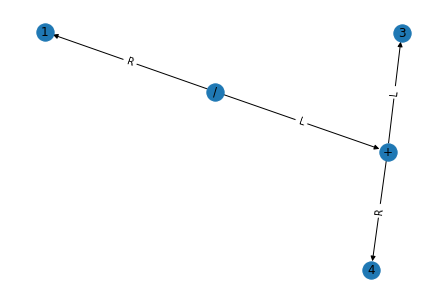

In [12]:
# expr = '1/(4+3)'
# heads = [1, -1, 4, 4, 1, 4, 4]

expr = '(3+4)/1'
heads = [2, 2, 5, 2, 2, -1, 5]

# expr = '3-4'
# heads = [1, -1, 1]

g = sample2graph(expr, heads, node_attr=NODE_ATTR)

pos = nx.spring_layout(g)
nx.draw(g, pos)
node_labels = nx.get_node_attributes(g,'sym')
nx.draw_networkx_labels(g, pos, labels = node_labels)
edge_labels = nx.get_edge_attributes(g,'dir')
nx.draw_networkx_edge_labels(g, pos, edge_labels)

# sample = RelationalSample(g, name='test', node_attr=NODE_ATTR)
sample = TreeSample(expr, heads, node_attr=NODE_ATTR)
print(len(sample.compounds))
print(sorted(sample.compounds, key=lambda x: len(str(x))))

In [13]:
train_exprs = [y for x in train_exprs for y in x]
mcd_exprs = [y for x in mcd_exprs for y in x]
print(len(train_exprs), len(mcd_exprs))
max_nodes_per_compound = 5
max_depth_compound = float('inf')

train_samples = [TreeSample(expr=x[0], heads=x[1], name = f'train_{i}', node_attr=NODE_ATTR,
                          max_nodes_per_compound = max_nodes_per_compound, max_depth_compound=max_depth_compound)
                        for i, x in enumerate(train_exprs)]
mcd_samples = [TreeSample(expr=x[0], heads=x[1], name = f'mcd_{i}', node_attr=NODE_ATTR,
                          max_nodes_per_compound = max_nodes_per_compound, max_depth_compound=max_depth_compound)
                        for i, x in enumerate(mcd_exprs)]

80400 34000


In [14]:
train_samples_partial = random.sample(train_samples, k=len(train_samples))
mcd_samples_partial = random.sample(mcd_samples, k=len(mcd_samples))

In [ ]:
pool_size = len(train_samples_partial) + len(mcd_samples_partial)
n_selected = 10000
max_compounds = 3000
cfg = DBCASplitterConfig(d_a=0.02, d_c=1.0, pool_size=pool_size, num_processes=1,
                         n_sample_per_step=100, max_compounds=max_compounds, use_compound_weight=True,
                         n_train=len(train_samples_partial), n_test=n_selected, save_dir="tmp", verbose=False)
if cfg.num_processes > 1:
    spg = DBCASplitterRay(train_samples_partial + mcd_samples_partial, cfg)
else:
    spg = DBCASplitter(train_samples_partial + mcd_samples_partial, cfg)
for sample in train_samples_partial:
    spg.add_sample_to_set(sample.id, spg.train_set)
spg.generate_splits()

if cfg.num_processes > 0:
    import ray
    ray.shutdown()

INFO:dbca.config:Setting logging level to 20
INFO:dbca.storage:Loading samples into storage...
100%|█████████████████████████| 114400/114400 [00:15<00:00, 7384.39it/s]
INFO:dbca.storage:Done!
INFO:dbca.full_sample_set:Loading 114400 samples...
100%|████████████████████████| 114400/114400 [00:09<00:00, 11488.07it/s]
INFO:dbca.full_sample_set:Computing weight for all 412294 compounds...
  0%|                         | 9/412294 [30:01<27117:30:36, 236.79s/it]

In [ ]:
100%|████████████████████████████████| 20/20 [1:33:16<00:00, 279.83s/it]
INFO:dbca.dbca_splitter:Finished creating dataset!
INFO:dbca.dbca_splitter:Train set size: 4400, test set size: 2000
INFO:dbca.dbca_splitter:D_A: 0.024547835836791543, D_C: 0.2191601685310356
INFO:dbca.dbca_splitter:Saving to test_reg...
INFO:dbca.dbca_splitter:Done!

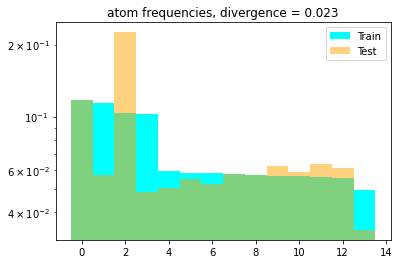

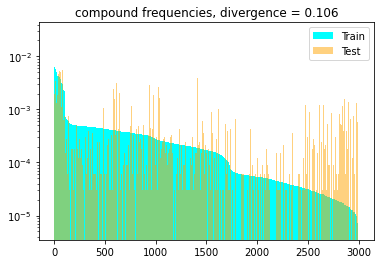

<module 'matplotlib.pyplot' from '/home/qing/.virtualenvs/hint/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [17]:
spg.visualize_dists('atom')
spg.visualize_dists('compound')

In [18]:
len(spg.test_set.sample_ids)

1500

In [6]:
split2dataset = {}
for split in splits:
    split2dataset[split] = json.load(open('expr_%s.json'%split))
    
split2symset = {}
for split in splits:
    split2symset[split] = json.load(open('sym_%s.json'%split))

In [15]:
max_nodes_per_compound = 5
max_depth_compound = 3
split2samples = {}

def map_number(expr):
    return ['n' if x in num_list else x for x in expr]

for split in splits:
    samples = [TreeSample(expr=x['expr'], heads=x['head'], name = f'{split}_{i}', node_attr=NODE_ATTR,
                          max_nodes_per_compound = max_nodes_per_compound, max_depth_compound=max_depth_compound) 
                     for i, x in enumerate(split2dataset[split])]
    split2samples[split] = samples

In [16]:
train_samples = split2samples['train']
all_samples = []
for split in splits:
    all_samples.extend(split2samples[split])
spg = DBCASplitter(all_samples, DBCASplitterConfig(use_compound_weight=False, max_compounds=3000))
for sample in tqdm(train_samples):
    spg.add_sample_to_set(sample.id, spg.train_set)

INFO:dbca.config:Setting logging level to 20
INFO:dbca.storage:Loading samples into storage...
100%|██████████████████████████| 137040/137040 [04:57<00:00, 461.19it/s]
INFO:dbca.storage:Done!
INFO:dbca.full_sample_set:Loading 137040 samples...
100%|████████████████████████| 137040/137040 [00:07<00:00, 18091.81it/s]
INFO:dbca.full_sample_set:Computing weight for all 141218 compounds...
100%|████████████████████████| 141218/141218 [00:03<00:00, 41218.28it/s]
INFO:dbca.full_sample_set:Keeping 3000/141218 highest weighted compounds.
100%|████████████████████████████| 84900/84900 [02:55<00:00, 484.21it/s]


In [17]:
for split in ['val', 'test']:
    samples = split2samples[split]
    dataset = split2dataset[split]
    for evaluation in ['I', 'SS', 'LS', 'SL', 'LL']:
        samples_eval = [x for x, y in zip(samples, dataset) if y['eval'] == evaluation]
        spg.test_set = SplitSampleSet(split="test")
        for sample in samples_eval:
            spg.unused_sample_ids.add(sample.id)
            spg.add_sample_to_set(sample.id, spg.test_set)
        print(f'{split}-{evaluation} ({len(samples_eval)}): AD {spg.atom_divergence}, CD {spg.compound_divergence}')

val-I (1100): AD 0.0003368805202171865, CD 0.012029658292481482
val-SS (800): AD 0.0003081636915347463, CD 0.012583214123693454
val-LS (1000): AD 0.0007648573642786705, CD 0.00857139801803608
val-SL (800): AD 0.05439624062393833, CD 0.08827668382464127
val-LL (1000): AD 0.01202623288196114, CD 0.03414709208166844
test-I (12900): AD 0.0001995788430643186, CD 0.0012403373019348463
test-SS (8000): AD 3.024638359661047e-05, CD 0.001357271118742509
test-LS (10000): AD 0.0006629669778629443, CD 0.005499056365079857
test-SL (6540): AD 0.046040251197732696, CD 0.07326302759684467
test-LL (10000): AD 0.011351363050201235, CD 0.030760354883142327


In [23]:
len(sorted(spg.full_sample_set.compound_weights.items(), key=lambda x: -x[1]))

3000

# 3. Data analysis

In [ ]:
bins = list(range(10)) + [10, max_value_train+1, max_value_test]

dataset = split2dataset['train']
#res_counts = Counter([x['res'] for x in dataset])
#print(sorted(list(res_counts.items())))

n, _, _ = plt.hist([x['res'] for x in dataset], bins=bins)
n = n/n.sum()
print(list(zip(bins, np.round(n*100, 2))))
#plt.show()
#print(random.sample(dataset, k=3))

dataset = split2dataset['val']
res_counts = Counter([x['res'] for x in dataset])
#print(sorted(list(res_counts.items())))
n, _, _ = plt.hist([x['res'] for x in dataset], bins=bins)
n = n/n.sum()
print(list(zip(bins, np.round(n*100, 2))))
#print(random.sample(dataset, k=3))

In [ ]:
# Visualize data
import numpy as np
for split in splits:
    dataset = split2dataset[split]
    print(split, len(dataset), np.max([x['res'] for x in dataset]))
    all_symbols = [(x, y) for sample in dataset for x, y in zip(sample['img_paths'], sample['expr'])]
    print(sorted(Counter([x[1] for x in all_symbols]).items()))
    print(sorted(Counter([x[1] for x in set(all_symbols)]).items()))
    for _ in range(5):
        sample = random.choice(dataset)
        img_paths = sample['img_paths']
        img = render_img(img_paths)
        print("".join(sample['expr']), sample['head'], sample['res_all'], sample['res'])
        display(img)

In [ ]:
img = Image.open(symbol_images_dir + '2/2_849.jpg')
print(img.size)
display(img)

expr = '3+4*2'
img_paths = generate_img_paths(expr, sym_set=split2sym['train'])
img = render_img(img_paths)
print(expr,'=', eval(expr))
display(img)

for sym in '019+-*/()':
    expr = sym*10
    img_paths = generate_img_paths(expr, sym_set=split2sym['train'])
    img = render_img(img_paths)
    display(img)


In [ ]:
def compute_depth(expr):
    depth = 0
    max_depth = 0
    for x in expr:
        if x == lps:
            c = 1
        elif x == rps:
            c = -1
        else:
            c = 0
        depth += c
        if depth > max_depth:
            max_depth = depth
    return max_depth

print(compute_depth('1*2*(1+2*((3+4)+(3-1))'))
ps_depths = [compute_depth(x['expr']) for x in split2dataset['train']]
print(Counter(ps_depths))

ps_depths = [compute_depth(x['expr']) for x in split2dataset['val']]
print(Counter(ps_depths))

In [ ]:
dataset = [x for x in split2dataset['train']]
for _ in range(10):
    sample = random.choice(dataset)
    img_paths = sample['img_paths']
    img = render_img(img_paths)
    print("".join(sample['expr']), sample['head'], sample['res_all'], sample['res'])
    display(img)

In [ ]:
for i in range(1, 6):
    print(i, '='*60)
    dataset = [x for x in split2dataset['test'] if x['eval'] == i]
    for _ in range(10):
        sample = random.choice(dataset)
        img_paths = sample['img_paths']
        img = render_img(img_paths)
        print("".join(sample['expr']), sample['head'], sample['res_all'], sample['res'])
        display(img)

# 4. Generate fewshot dataset

In [ ]:
fewshot_concepts = list('abcde')
op2precedence.update({'a': 2, 'b': 2, 'c': 3, 'd': 3, 'e': 4})
op2arity.update({'a': 2, 'b': 2, 'c': 2, 'd': 2, 'e': 2})
functions = [lambda x,y: max(x, y), lambda x,y: min(x, y), lambda x,y: math.ceil((x+y)/2), 
             lambda x,y: max(0, (x*y)-(x+y)), lambda x,y: x**y if y < 10 else None]
programs = [Program(f) for f in functions]
SYM2PROG.update(dict(zip(fewshot_concepts, functions)))

In [ ]:
random.seed(12306)
max_op = 20
max_op_train = 10

for i, fs in enumerate(fewshot_concepts):
    if i != 3:
        continue
    train_exprs = []
    val_exprs = []
    test_exprs = []
    n_test = 10
    n_val = 10
    
    op_list = ['+', '-', '*', '/', fs]
    
    # generate symbolic expression
    for n_op in range(max_op + 1):
        n_train = 20 if n_op == 1 else 10
        if n_op > max_op_train:
            n_train = 0
        expressions = generate_expression(n_op, 1000, max_value=max_value_train)
        expressions = [x for x in expressions if fs in x[0]]

        if n_train > 0:
            train_exprs.append(expressions[:n_train])
        val_exprs.append(expressions[:min(n_val, n_train)] + expressions[n_train:n_train+n_val])
        test_exprs.append(expressions[:n_train + n_test])

        expressions = generate_expression(n_op, 1000, 
                              min_value=max_value_train+1, max_value=max_value_test, non_zero_res=True)
        expressions = [x for x in expressions if fs in x[0]]
        val_exprs[-1].extend(expressions[:n_val])
        test_exprs[-1].extend(expressions[:n_test])

        print(n_op, len(train_exprs[-1]) if n_train > 0 else 0, len(val_exprs[-1]), len(test_exprs[-1]))

    split2exprs = {'train': train_exprs, 'val': val_exprs, 'test': test_exprs}
    print([(k, sum([len(x) for x in v])) for k, v in split2exprs.items()])
    
    # generate handwritten expression
    split2dataset = {}
    for split in splits:
        sym_set = split2sym[split]
        exprs = split2exprs[split]
        dataset = []
        idx = 0
        for n_op, expr_list in enumerate(exprs):
            n_instance = 1
            if split == 'val':
                n_instance *= 0.1
            for e in expr_list:
                for _ in range(int(math.ceil(n_instance))):
                    img_paths = generate_img_paths(e[0], sym_set)
                    sample = {'id': '%s_%08d'%(split, idx), 'img_paths':img_paths, 
                          'expr': e[0], 'head': e[1], 'res': e[2], 'res_all': e[3]}
                    idx += 1
                    dataset.append(sample)
        split2dataset[split] = dataset
        print(split, len(dataset))
    
    # generate evaluation flag
    train_exprs = {x['expr'] for x in split2dataset['train']}
    max_len_train = max([len(x) for x in train_exprs])
    print(max_len_train)
    for split in ['val', 'test']:
        dataset = split2dataset[split]
        for sample in dataset:
            expr = sample['expr']
            if expr in train_exprs:
                evaluation = 1
            elif len(expr) <= max_len_train:
                max_value = max([x for x in sample['res_all'] if x is not None])
                if max_value <= max_value_train:
                    evaluation = 2
                else:
                    evaluation = 3
            else:
                max_value = max([x for x in sample['res_all'] if x is not None])
                if max_value <= max_value_train:
                    evaluation = 4
                else:
                    evaluation = 5
            sample['eval'] = evaluation
    
    # save
    for split in splits:
        json.dump(split2dataset[split], open('fewshot_%d_expr_%s.json'%(i, split), 'w'))

In [ ]:
counts = sorted(Counter([x['eval'] for x in split2dataset['test']]).items())
total_count = sum([c for _, c in counts])
counts = [(k, round(v/total_count*100, 2)) for k, v in counts]
print(counts)
print(list({x['expr'] for x in split2dataset['test'] if x['eval'] == 3})[:10])
train_exprs = {x['expr'] for x in split2dataset['train']}
max_len_train = max([len(x) for x in train_exprs])
print(max_len_train)

# Visualize data
import numpy as np
for split in splits:
    dataset = split2dataset[split]
    print(split, len(dataset), np.max([x['res'] for x in dataset]))
    all_symbols = [(x, y) for sample in dataset for x, y in zip(sample['img_paths'], sample['expr'])]
    print(sorted(Counter([x[1] for x in all_symbols]).items()))
    print(sorted(Counter([x[1] for x in set(all_symbols)]).items()))
    for _ in range(5):
        sample = random.choice(dataset)
        img_paths = sample['img_paths']
        img = render_img(img_paths)
        print("".join(sample['expr']), sample['head'], sample['res_all'], sample['res'])
        display(img)